# A simple istropic hardening plasticity algorithm

In this notebook, we will combine what we have built in the previous ones to solve a plasticity problem, which will be a system of implicit equations. \
Let us define the problem. We will deal will a simple 1D mechanical problem, with constitutive equation:
$$
\sigma = K\varepsilon_{el},
$$
where $K$ is the bulk modulus and $\varepsilon_{el}$ the elastic part of the strain.
We define a simple plastic potential:
$$
f(\sigma) = \sigma-\sigma_c,
$$
where $\sigma_c$ is the yield stress, and with the following hardening law:
$$
\dot{\sigma}_c = h\dot{\varepsilon}_p \sigma_c,
$$
where $h$ is a hardening parameter and $\varepsilon^p$ the plastic strain. \
In the elastic domain, the problem is trivial as $\sigma$ and $\varepsilon$ have a linear relationship ($\varepsilon=\varepsilon_{el}$ as $\varepsilon_p=0$). \
In plasticity, we have to solve the following system:

$$
\left\{
\begin{align}
\dot{\varepsilon} &= \dot{\varepsilon}_{el} + \dot{\varepsilon}_p, \\
f(\sigma) &= 0, \\
\dot{\sigma}_c &= h\dot{\varepsilon}_p \sigma_c.
\end{align}
\right.
$$

$\dot{\varepsilon}^p$ can be expressed from the plastic flow rule:

$$
\dot{\varepsilon}_p = \dot{\lambda}\frac{\partial f}{\partial \sigma} = \dot{\lambda},
$$

as $\partial f/\partial \sigma=1$ in our case, with $\lambda$ the plastic multiplier.\
In this classical plasticity problem, we have 3 variables: $\varepsilon^{el}$, $\lambda$ and $\sigma_c$. We will descretize our problem so that:

$$
\begin{align}
\varepsilon_{el}^{n+1} &= \varepsilon_{el}^{n} + \Delta\varepsilon_{el}, \\
\lambda^{n+1} &= \lambda^{n} + \Delta\lambda, \\
\sigma_c^{n+1} &= \sigma_c^n + \Delta\sigma_c,
\end{align}
$$

which allows us to rewrite our system in a discretized way:

$$
\left\{
\begin{align}
&\Delta\varepsilon = \Delta\varepsilon_{el} + \Delta\lambda, \\
&f(\sigma^{n+1}) = 0, \\
&\Delta\sigma_c = h\Delta\lambda \sigma_c^{n+1}.
\end{align}
\right.
$$

Notice that we chose to use an implicit formulation for the hardening law. Expanding all expressions to make our unknown appear ($\Delta\varepsilon_{el}$, $\Delta\lambda$ and $\Delta\sigma_c$), we get:

$$
({\bf F})=\left\{
\begin{align}
&\Delta\varepsilon_{el} + \Delta\lambda = \Delta\varepsilon, \\
&\Delta\sigma_c = \sigma^{n+1}-\sigma_c^n, \\
&\Delta\sigma_c - h\Delta\lambda\Delta\sigma_c - h\sigma_c^{n}\Delta\lambda =0.
\end{align}
\right.
$$

The constitutive equation $\sigma = K\varepsilon_{el}$ allows to rewrite $\sigma^{n+1} = K(\varepsilon_{el}^n +\Delta\varepsilon_{el})$, finally giving the system:

$$
({\bf F})=\left\{
\begin{align}
&\Delta\varepsilon_{el} + \Delta\lambda = \Delta\varepsilon, \\
&\Delta\sigma_c - K\Delta\varepsilon_{el} = \sigma^n-\sigma_c^n, \\
&\Delta\sigma_c - h\Delta\lambda\Delta\sigma_c - h\sigma_c^{n}\Delta\lambda = 0.
\end{align}
\right.
$$

Given the current state of the system at step $n$ and a strain increment $\Delta\varepsilon$, we can calculate the new values by solving the above nonlinear system. Let us implement it.

In [22]:
import numpy as np
import matplotlib.pyplot as plt


def F(dX, sig_n, sig_c_n, deps, K, h):
    deps_el, dlam, dsig_c = dX
    return np.array(
        [
            deps_el + dlam - deps,
            dsig_c - K * deps_el - sig_n + sig_c_n,
            dsig_c - h * dlam * dsig_c - h * sig_c_n * dlam,
        ]
    )


def J(dX, sig_c_n, K, h):
    deps_el, dlam, dsig_c = dX

    df1_ddeps_el = 1
    df1_ddlam = 1
    df1_ddsig_c = 0
    df2_ddeps_el = -K
    df2_ddlam = 0
    df2_ddsig_c = 1
    df3_ddeps_el = 0
    df3_ddlam = -h * dsig_c - h * sig_c_n
    df3_ddsig_c = 1 - h * dlam

    return np.array(
        [
            [df1_ddeps_el, df1_ddlam, df1_ddsig_c],
            [df2_ddeps_el, df2_ddlam, df2_ddsig_c],
            [df3_ddeps_el, df3_ddlam, df3_ddsig_c],
        ]
    )


def newton_method(residu, jacobian, initial_guess, tolerance, max_iteration=50):
    X_n = initial_guess
    iteration = 0
    while np.linalg.norm(residu(X_n)) > tolerance and iteration < max_iteration:
        X_n -= np.dot(np.linalg.inv(jacobian(X_n)), residu(X_n))
        iteration += 1
    if np.linalg.norm(residu(X_n)) > tolerance:  # Not converged
        print("Did not converge after {} iterations.".format(iteration))
    return X_n

In [34]:
# Material properties
K = 1e10  # [Pa]
h = 3000.0  # [-]

# Load step
deps = 5e-5

# Initial values
eps = [0.0]
eps_el = [0.0]
sig = [0.0]
lam = [0.0]
sig_c = [1e6]  # [Pa]


def integrator(eps, deps, eps_el, lam, sig_c):
    eps += deps
    sig_trial = K * eps
    if sig_trial < sig_c:
        eps_el += deps
        return eps, eps_el, lam, sig_c
    else:
        deps_el, dlam, dsig_c = newton_method(
            lambda X: F(X, K * eps_el, sig_c, deps, K, h),
            lambda X: J(X, sig_c, K, h),
            np.array([0.0, 0.0, 0.0]),
            1e-6,
        )
        return eps, eps_el + deps_el, lam + dlam, sig_c + dsig_c


for i in range(10):
    eps_, eps_el_, lam_, sig_c_ = integrator(
        eps[-1], deps, eps_el[-1], lam[-1], sig_c[-1]
    )
    eps.append(eps_)
    eps_el.append(eps_el_)
    lam.append(lam_)
    sig_c.append(sig_c_)
    sig.append(K * eps_el_)

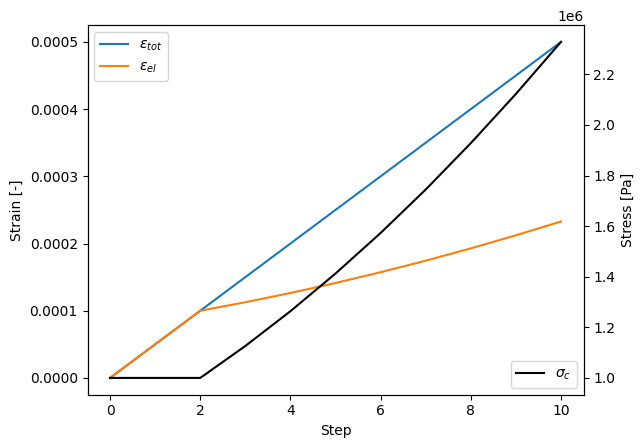

In [35]:
plt.plot(range(11), eps, label=r"$\varepsilon_{tot}$")
plt.plot(range(11), eps_el, label=r"$\varepsilon_{el}$")
plt.xlabel(r"Step")
plt.ylabel(r"Strain [-]")
plt.legend()
plt.twinx()
plt.plot(range(11), sig_c, "k-", label=r"$\sigma_c$")
plt.ylabel(r"Stress [Pa]")
plt.legend(loc="lower right")

Text(0, 0.5, 'Stress [Pa]')

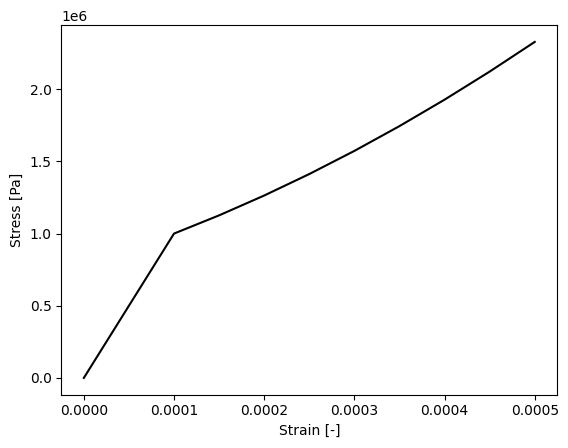

In [37]:
plt.plot(eps, sig, "k-")
plt.xlabel(r"Strain [-]")
plt.ylabel(r"Stress [Pa]")

## Handling the consistent tangent operator in plasticity

Here we have implemented a simple, strain-controlled hardening plasticity model. But what about stress controlled? For the sake of generality, let us say in a general context that we want to control the thermodynamic forces (here $\sigma$) rather than the variables (here $\varepsilon$). \
In that case, we need another layer of **Newton-Raphson** to determine the thermodynamic variables as a function of the forces. There is however a notable subtlety here with plasticity: the relationship between $\sigma$ and $\varepsilon$ is not direct, however the Newton-Raphson algorithm requires the knowledge of the tangent stiffness $K_t = \mathrm{d}\sigma/\mathrm{d}\Delta\varepsilon$. \
It can be calculated in the following manner:

$$
\frac{\mathrm{d}\sigma}{\mathrm{d}\Delta\varepsilon} = \frac{\partial\sigma}{\partial\Delta\varepsilon} + \frac{\partial\sigma}{\partial\Delta{\bf X}} \frac{\mathrm{d}\Delta{\bf X}}{\mathrm{d}\Delta\varepsilon},
$$

where ${\bf X}$ represents the vector of internal variables (in the above example $\varepsilon_{el}$, $\lambda$ and $\sigma_c$).\
Differentiation of the implicit system $F$ with respect to $\Delta\varepsilon$ yields:

$$
\frac{\mathrm{d}{\bf F}}{\mathrm{d}\Delta\varepsilon} = \frac{\partial{\bf F}}{\partial\Delta\varepsilon} + \frac{\partial{\bf F}}{\partial\Delta{\bf X}} \frac{\mathrm{d}\Delta{\bf X}}{\mathrm{d}\Delta\varepsilon} = 0,
$$

where

$$
J = \frac{\partial{\bf F}}{\partial\Delta{\bf X}}
$$

is the ***jacobian matrix*** of the system, allowing to express the term $\mathrm{d}\Delta{\bf X}/\mathrm{d}\Delta\varepsilon$ as:

$$
\frac{\mathrm{d}\Delta{\bf X}}{\mathrm{d}\Delta\varepsilon} = - J^{-1}\cdot\frac{\partial{\bf F}}{\partial\Delta\varepsilon}.
$$

Generally, $\partial{\bf F}/\partial\Delta\varepsilon$ is a pretty sparse vector (in our case only the first equation in $F$ has a term in $\Delta\varepsilon$), so in practice the entire inverse of $J$ is not required (only a part of it). We will however leave such optimization for later. \
Back to our previous example:

$$
\frac{\partial{\bf F}}{\partial\Delta\varepsilon} =
\begin{bmatrix}
-1 \\
0 \\
0
\end{bmatrix},
$$

and we already have our jacobian matrix $J$. The partial derivative of $\sigma$ with respect to the vector of internal variables' increments $\Delta{\bf X}$ is also trivial as the stress $\sigma$ only depends on the elastic strain $\varepsilon_{el}$:

$$
\frac{\partial\sigma}{\partial\Delta{\bf X}} = 
\begin{bmatrix}
K \\
0 \\
0
\end{bmatrix}.
$$

Since $\partial\sigma/\partial\Delta\varepsilon = 0$ because stress doesn't depend on the total strain in plasticity, the tangent stiffness is:

$$
K_t = \frac{\mathrm{d}\sigma}{\mathrm{d}\Delta\varepsilon} = -
\begin{bmatrix}
K & 0 & 0
\end{bmatrix}
\cdot J^{-1}\cdot
\begin{bmatrix}
-1\\
0\\
0
\end{bmatrix}.
$$

Let us take the previous example but now use increments of stress $\Delta\sigma$.

In [40]:
# Load step
dsig = 2.5e5  # [Pa]

# Initial values
eps = [0.0]
eps_el = [0.0]
sig = [0.0]
lam = [0.0]
sig_c = [1e6]  # [Pa]

# Tolerance on stress
sig_tol = dsig / 1e6


def integrator_with_tangent(eps, deps, eps_el, lam, sig_c):
    eps += deps
    sig_trial = K * eps
    if sig_trial < sig_c:
        eps_el += deps
        return eps, eps_el, lam, sig_c, K
    else:
        dX = newton_method(
            lambda X: F(X, K * eps_el, sig_c, deps, K, h),
            lambda X: J(X, sig_c, K, h),
            np.array([0.0, 0.0, 0.0]),
            1e-6,
        )
        deps_el, dlam, dsig_c = dX
        K_t = -np.dot(
            np.array([K, 0, 0]),
            np.dot(np.linalg.inv(J(dX, sig_c + dsig_c, K, h)), np.array([-1, 0, 0])),
        )
        return eps, eps_el + deps_el, lam + dlam, sig_c + dsig_c, K_t


for i in range(10):
    sig_goal = sig[-1] + dsig
    sig_ = sig[-1]
    deps = 0
    while abs(sig_goal - sig_) > sig_tol:
        eps_, eps_el_, lam_, sig_c_, K_t = integrator_with_tangent(
            eps[-1], deps, eps_el[-1], lam[-1], sig_c[-1]
        )
        sig_ = K * eps_el_
        deps += (sig_goal - sig_) / K_t
    eps.append(eps_)
    eps_el.append(eps_el_)
    lam.append(lam_)
    sig_c.append(sig_c_)
    sig.append(K * eps_el_)

Text(0, 0.5, 'Stress [Pa]')

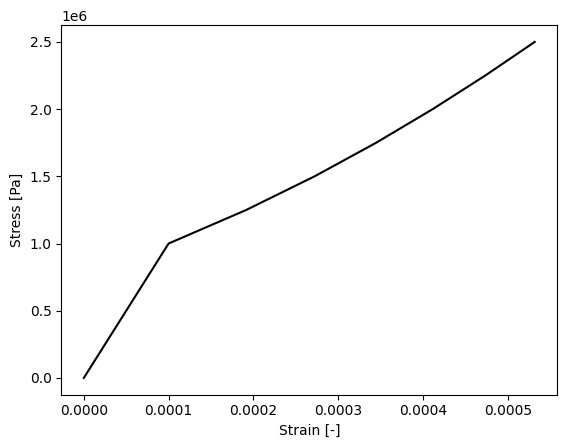

In [41]:
plt.plot(eps, sig, "k-")
plt.xlabel(r"Strain [-]")
plt.ylabel(r"Stress [Pa]")